## Phase 4 Project: Pneumonia and Neural Networks

**Deanna Gould**  
Instructor: Morgan Jones  
Presentation Date: 


In [1]:
# Importing libraries

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import (plot_confusion_matrix, confusion_matrix, classification_report, roc_curve, auc, 
                             RocCurveDisplay)
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

### Creating Functions

In [24]:
# Plot history

def plot_history(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'blue', label='Training accuracy')
    plt.plot(epochs, val_acc, 'blue', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    plt.show()

In [22]:
# Code below from stack overflow
# https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict%20%20%20%20%20-generator/67282636#67282636

def pred_labels(model, generator):

# Create lists for storing the predictions and labels
    predictions = []
    labels = []

# Get the total number of labels in generator 
# (i.e. the length of the dataset where the generator generates batches from)
    n = len(generator.labels)

# Loop over the generator
    for data, label in generator:
    # Make predictions on data using the model. Store the results.
        predictions.extend(model.predict(data).flatten())

    # Store corresponding labels
        labels.extend(label)

    # We have to break out from the generator when we've processed 
    # the entire once (otherwise we would end up with duplicates). 
        if (len(label) < generator.batch_size) and (len(predictions) == n):
            break
    return labels, predictions

base model, grid search model, tune model after gs, transfer learning (pre trained model), tune transfer learning

In [2]:
# Making directories

train_dir = "data/chest_xray/chest_xray/train"
val_dir = "data/chest_xray/chest_xray/val"
test_dir = "data/chest_xray/chest_xray/test"

In [3]:
# Getting value counts for directories


print('train_set:')
print('---------')
pneu_count_tr = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
normal_count_tr = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f'Pneumonia = {pneu_count_tr}')
print(f'Normal = {normal_count_tr}')
print('\n')
print('val_set:')
print('---------')
pneu_count_val = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
normal_count_val = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
print(f'Pneumonia = {pneu_count_val}')
print(f'Normal = {normal_count_val}')
print('\n')
print('test_set:')
print('---------')
pneu_count_test = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
normal_count_test = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
print(f'Pneumonia = {pneu_count_test}')
print(f'Normal = {normal_count_test}')
print('\n') 

train_set:
---------
Pneumonia = 3676
Normal = 1142


val_set:
---------
Pneumonia = 209
Normal = 209


test_set:
---------
Pneumonia = 390
Normal = 234




In [4]:
normal_count_val

209

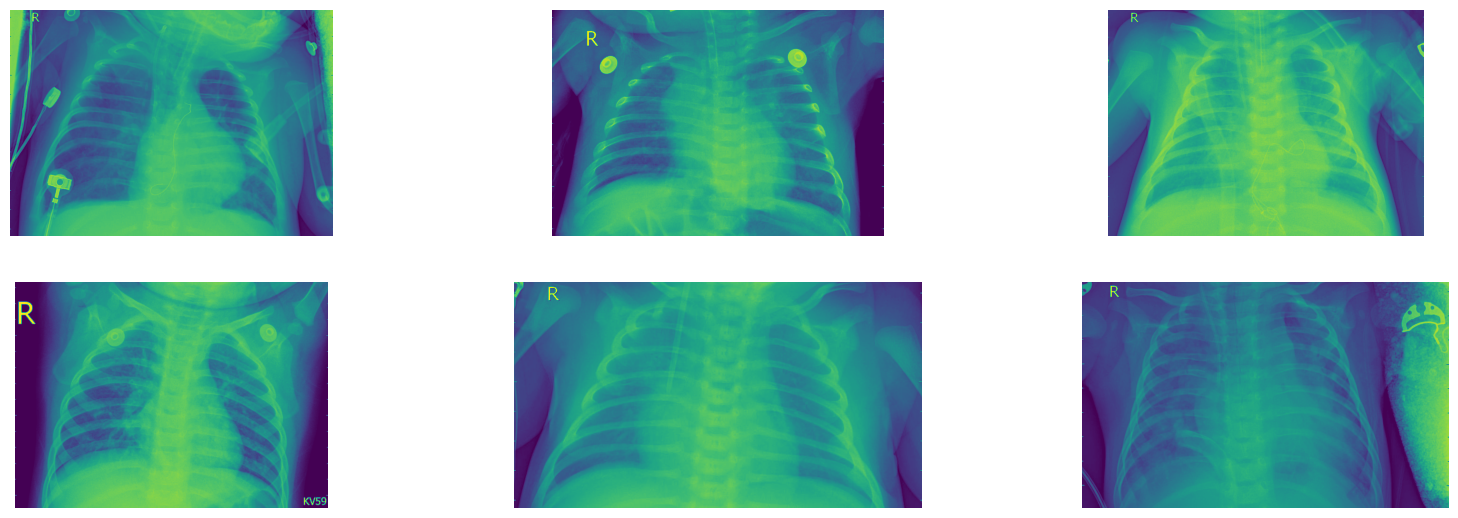

In [5]:
# Displaying Pneumonia X-rays
pneumonia = os.listdir("data/chest_xray/chest_xray/train/PNEUMONIA")
pneumoniadir = "data/chest_xray/chest_xray/train/PNEUMONIA"

plt.figure(figsize = (20, 10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    image = plt.imread(os.path.join(pneumoniadir, pneumonia[i]))
    plt.imshow(image)
    plt.axis('off')

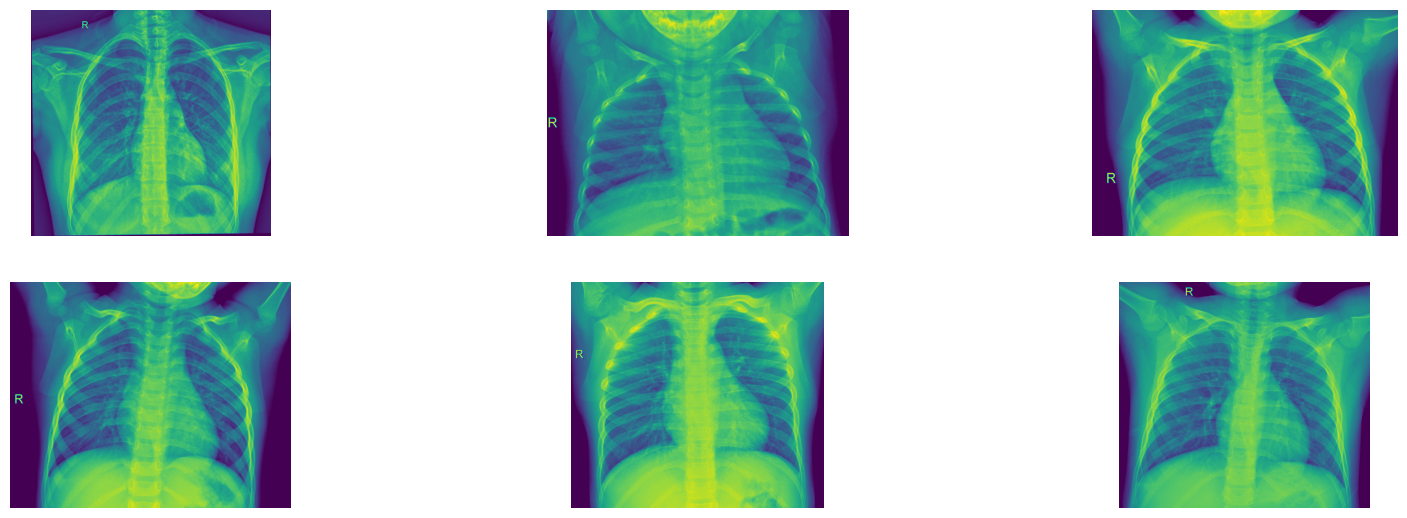

In [6]:
# Displaying Normal X-rays
normal = os.listdir("data/chest_xray/chest_xray/train/NORMAL")
normaldir = "data/chest_xray/chest_xray/train/NORMAL"

plt.figure(figsize = (20, 10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    image = plt.imread(os.path.join(normaldir, normal[i]))
    plt.imshow(image)
    plt.axis('off')

In [7]:
normal_img = plt.imread(os.path.join(normaldir, normal[0]))
normal_img

array([[ 0, 23, 24, ...,  0,  0,  0],
       [ 0,  5, 23, ...,  0,  0,  0],
       [ 1,  0, 26, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [8]:
pneumonia_img = plt.imread(os.path.join(pneumoniadir, pneumonia[0]))
pneumonia_img

array([[210, 208, 206, ..., 213, 215, 216],
       [210, 208, 206, ..., 213, 216, 217],
       [210, 208, 205, ..., 213, 216, 218],
       ...,
       [ 16,  15,  14, ...,  47,  47,  47],
       [ 16,  15,  14, ...,  46,  46,  46],
       [ 16,  15,  14, ...,  46,  46,  46]], dtype=uint8)

<AxesSubplot:ylabel='Count'>

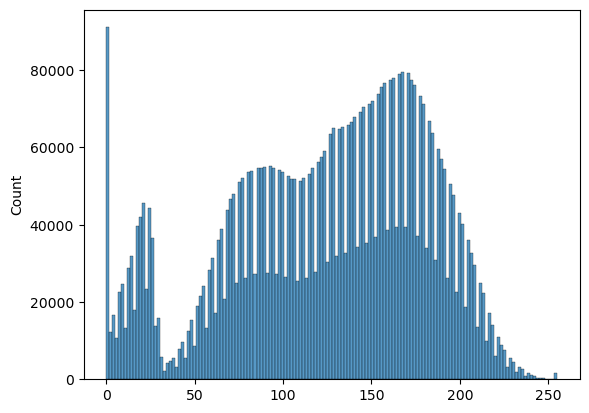

In [9]:
sns.histplot(normal_img.ravel(), bins = 150)

<AxesSubplot:ylabel='Count'>

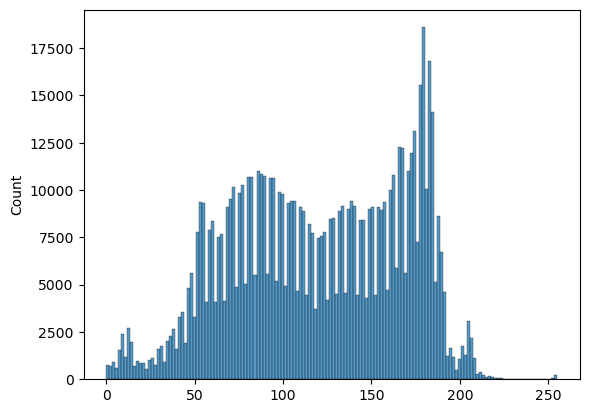

In [10]:
sns.histplot(pneumonia_img.ravel(), bins = 150)

vgg 16 vggg 19 resnet 150

#### Image Generator

In [11]:
# Separating train and val datagen

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(224, 224), 
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    shuffle = True)

validation_generator = val_datagen.flow_from_directory(val_dir,
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='binary',
                                                        shuffle = True)

Found 4816 images belonging to 2 classes.
Found 416 images belonging to 2 classes.


In [12]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [13]:
validation_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [14]:
weight_pneu = pneu_count_tr / (pneu_count_tr + normal_count_tr)

weight_normal = normal_count_tr / (pneu_count_tr + normal_count_tr)

class_weight = {0 : weight_pneu, 1 : weight_normal}
print(f'0 Weight Class = {weight_pneu}')
print(f'1 Weight Class = {weight_normal}')

0 Weight Class = 0.7629721876297219
1 Weight Class = 0.23702781237027812


train generator is basically standard scaling for images


#### Baseline Model

In [15]:
#Initiating the model
modelone = models.Sequential()

# Input layer
modelone.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
modelone.add(layers.MaxPooling2D((2, 2)))

#Hidden Layer
modelone.add(layers.Flatten())
modelone.add(layers.Dense(64, activation='relu'))

#Output Layer
modelone.add(layers.Dense(1, activation='sigmoid'))

modelone.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)
                )

2023-09-17 13:06:55.682278: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 13:06:55.703398: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff2e7e5f570 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-17 13:06:55.703411: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Only thing that will change is optimizer

In [16]:
modelone.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 394272)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                25233472  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 25,234,433
Trainable params: 25,234,433
Non-trainable params: 0
_________________________________________________________________


In [26]:
historyone = modelone.fit(train_generator, 
                              epochs=10, 
                              validation_data=validation_generator,
                              class_weight = class_weight,
                              steps_per_epoch = 100,
                              validation_steps=10)

Epoch 1/10
100/100 [==============================] - 82s 818ms/step - loss: 0.0345 - binary_accuracy: 0.9639 - val_loss: 0.0877 - val_binary_accuracy: 0.9844
Epoch 2/10
100/100 [==============================] - 73s 732ms/step - loss: 0.0308 - binary_accuracy: 0.9670 - val_loss: 0.1311 - val_binary_accuracy: 0.9406
Epoch 3/10
100/100 [==============================] - 64s 644ms/step - loss: 0.0316 - binary_accuracy: 0.9664 - val_loss: 0.2197 - val_binary_accuracy: 0.9125
Epoch 4/10
100/100 [==============================] - 64s 642ms/step - loss: 0.0273 - binary_accuracy: 0.9719 - val_loss: 0.0849 - val_binary_accuracy: 0.9875
Epoch 5/10
100/100 [==============================] - 64s 641ms/step - loss: 0.0228 - binary_accuracy: 0.9762 - val_loss: 0.1297 - val_binary_accuracy: 0.9406
Epoch 6/10
100/100 [==============================] - 65s 646ms/step - loss: 0.0249 - binary_accuracy: 0.9746 - val_loss: 0.0935 - val_binary_accuracy: 0.9656
Epoch 7/10
100/100 [==========================

training and validation accuracy
roc auc
confusion matrix

#### Baseling training validation accuracy

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

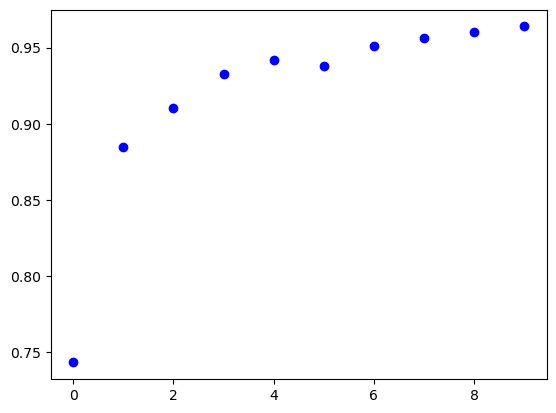

In [25]:
plot_history(historyone)

In [ ]:
pred_labels(modelone, train_generator)

### Baseline HParams (gridsearch)

In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'binary_accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

In [ ]:
# function for plotting rocauc

### Tuning Model

testing changes
